# Vlasov-Poisson 

In this notebook we present a multithreaded version of the Vlasov-Poisson system in 1D1D phase space.
Equations are solved numerically using semi-lagrangian method. 

 ## Semi-Lagrangian method

 Let us consider an abstract scalar advection equation of the form
 $$
 \frac{\partial f}{\partial t}+ a(x, t) \cdot \nabla f = 0. 
 $$
 The characteristic curves associated to this equation are the solutions of the ordinary differential equations
 $$
 \frac{dX}{dt} = a(X(t), t)
 $$
 We shall denote by $X(t, x, s)$ the unique solution of this equation associated to the initial condition $X(s) = x$.

 The classical semi-Lagrangian method is based on a backtracking of characteristics. Two steps are needed to update the distribution function $f^{n+1}$ at $t^{n+1}$ from its value $f^n$ at time $t^n$ :
 1. For each grid point $x_i$ compute $X(t^n; x_i, t^{n+1})$ the value of the characteristic at $t^n$ which takes the value $x_i$ at $t^{n+1}$.
 2. As the distribution solution of first equation verifies 
 $$f^{n+1}(x_i) = f^n(X(t^n; x_i, t^{n+1})),$$
 we obtain the desired value of $f^{n+1}(x_i)$ by computing $f^n(X(t^n;x_i,t^{n+1})$ by interpolation as $X(t^n; x_i, t^{n+1})$ is in general not a grid point.

 *[Eric Sonnendrücker - Numerical methods for the Vlasov equations](http://www-m16.ma.tum.de/foswiki/pub/M16/Allgemeines/NumMethVlasov/Num-Meth-Vlasov-Notes.pdf)*


In [1]:
import sys

if sys.platform == "darwin":
    %env CC='gcc-10'

env: CC='gcc-10'


## Bspline

The `bspline` function return the value at x in [0,1[ of the B-spline with 
integer nodes of degree p with support starting at j.
Implemented recursively using the de Boor's recursion formula

[De Boor's Algorithm - Wikipedia](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)

In [2]:
import numpy as np
from scipy.fftpack import fft, ifft 

def bspline_python(p, j, x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        assert (x >= 0.0) & (x <= 1.0)
        assert (type(p) == int) & (type(j) == int)
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_python(p - 1, j, x) + (1 - w1) * bspline_python(p - 1, j + 1, x)

In [3]:
class Advection:
    
    """ Class to compute BSL advection of 1d function """
    
    def __init__(self, p, xmin, xmax, ncells, bspline):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        self.bspline = bspline
        self.eig_bspl = bspline(p, -(p + 1) // 2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def __call__(self, f, alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p-1)//2, (p+1)//2 + 1):
            self.eigalpha += self.bspline(p, j-(p+1)//2, beta) * np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))

In [4]:
def interpolation_test(bspline):
    """ Test to check interpolation"""
    n = 64
    cs = Advection(3,0,1,n, bspline)
    x = np.linspace(0,1,n, endpoint=False)
    f = np.sin(x*4*np.pi)
    alpha = 0.2
    return np.allclose(np.sin((x-alpha)*4*np.pi), cs(f, alpha))
    

interpolation_test(bspline_python)


True

If we profile the code we can see that a lot of time is spent in `bspline` calls

## Accelerate with Fortran

In [5]:
%load_ext fortranmagic

In [6]:
%%fortran
recursive function bspline_fortran(p, j, x) result(res)
    integer :: p, j
    real(8) :: x, w, w1
    real(8) :: res

    if (p == 0) then
        if (j == 0) then
            res = 1.0
            return
        else
            res = 0.0
            return
        end if
    else
        w = (x - j) / p
        w1 = (x - j - 1) / p
    end if
    
    res = w * bspline_fortran(p-1,j,x) &
    +(1-w1)*bspline_fortran(p-1,j+1,x)

end function bspline_fortran

In [7]:
interpolation_test(bspline_fortran)

True

## Numba

Create a optimized function of bspline python function with Numba. Call it bspline_numba.

In [8]:
from numba import jit,  int32, float64
from scipy.fftpack import fft, ifft

@jit("float64(int32,int32,float64)",nopython=True)
def bspline_numba(p, j, x):
    
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        
        assert ((x >= 0.0) & (x <= 1.0))
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x-j)/p
            w1 = (x-j-1)/p
        return w * bspline_numba(p-1,j,x)+(1-w1)*bspline_numba(p-1,j+1,x)

In [9]:
interpolation_test(bspline_numba)

True

## Pythran

In [10]:
import pythran

%load_ext pythran.magic

In [11]:
%%pythran

import numpy as np

#pythran export bspline_pythran(int,int,float64)
def bspline_pythran(p, j, x):
    if p == 0:
        if j == 0:
            return 1.0
        else:
            return 0.0
    else:
        w = (x-j)/p
        w1 = (x-j-1)/p
    return w * bspline_pythran(p-1,j,x)+(1-w1)*bspline_pythran(p-1,j+1,x)

In [12]:
interpolation_test(bspline_pythran)

True

## Cython

In [13]:
%load_ext cython

In [14]:
%%cython -a
def bspline_cython(p, j, x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        assert (x >= 0.0) & (x <= 1.0)
        assert (type(p) == int) & (type(j) == int)
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_cython(p - 1, j, x) + (1 - w1) * bspline_cython(p - 1, j + 1, x)

In [15]:
%%cython
import cython

@cython.cdivision(True)
cpdef double bspline_cython(int p, int j, double x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        cdef double w, w1
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_cython(p-1,j,x)+(1-w1)*bspline_cython(p-1,j+1,x)

In [16]:
interpolation_test(bspline_cython)

True

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (11,7)

In [18]:
from tqdm.notebook import tqdm
from collections import defaultdict

Mrange = (2 ** np.arange(6, 12)).astype(int)
opts = [bspline_fortran, bspline_pythran, bspline_cython, bspline_numba]

times = defaultdict(list)
for M in tqdm(Mrange):
    x = np.linspace(0, 1, M, endpoint=False)
    for opt in opts:
        f = np.sin(x*4*np.pi)
        cs = Advection(5, 0, 1, M, opt)
    
        alpha = 0.1
        ts = %timeit -oq -n 100 cs(f, alpha)
        times[opt.__name__].append(ts.best)

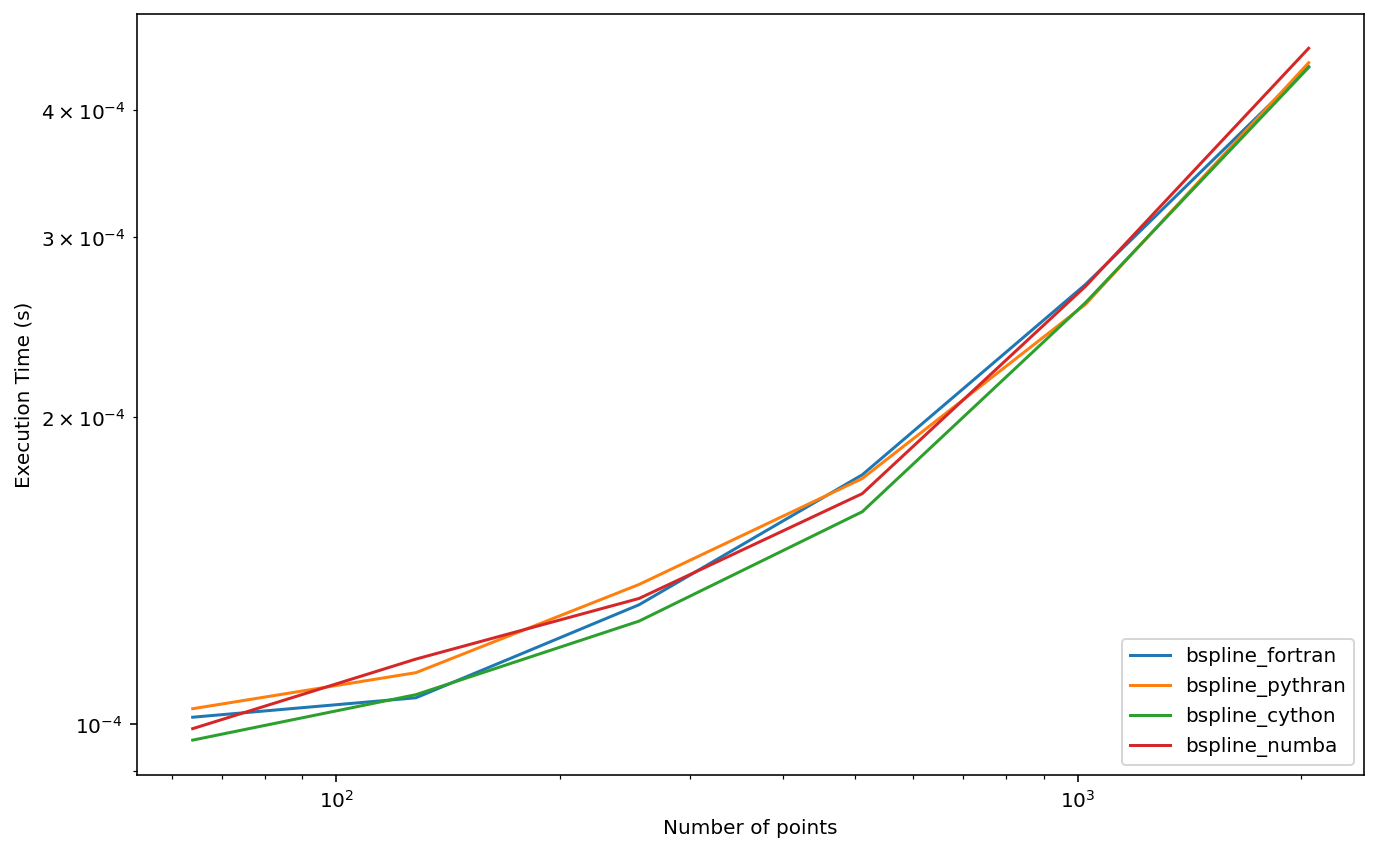

In [19]:
for o, t in times.items():
    plt.loglog(Mrange, t, label=o)
    
plt.legend(loc='lower right')
plt.xlabel('Number of points')
plt.ylabel('Execution Time (s)');

In [20]:
%%cython
import cython
import numpy as np
cimport numpy as np
from scipy.fftpack import fft, ifft

@cython.cdivision(True)
cdef double bspline_cython(int p, int j, double x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        cdef double w, w1
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline_cython(p-1,j,x)+(1-w1)*bspline_cython(p-1,j+1,x)

class BSplineCython:
    
    def __init__(self, p, xmin, xmax, ncells):
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline_cython(p,-(p+1)//2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline_cython(p,j-(p+1)//2,0.0)*2*np.cos(j*self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def __call__(self,  f,  alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        cdef Py_ssize_t j
        cdef int p = self.p
        # compute eigenvalues of cubic splines evaluated at displaced points
        cdef int ishift = np.floor(-alpha / self.deltax)
        cdef double beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0)
        for j in range(-(p-1)//2, (p+1)//2+1):
            self.eigalpha += bspline_cython(p,j-(p+1)//2,beta)*np.exp((ishift+j)*1j*self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(ifft(fft(f) * self.eigalpha / self.eig_bspl))




In [21]:
times["cython"] = []
for M in tqdm(Mrange):
    x = np.linspace(0, 1, M, endpoint=False)
    f = np.sin(x*4*np.pi)
    cs = BSplineCython(5, 0, 1, M )
    
    alpha = 0.1
    ts = %timeit -oq -n 100 cs(f, alpha)
    times["cython"].append(ts.best)

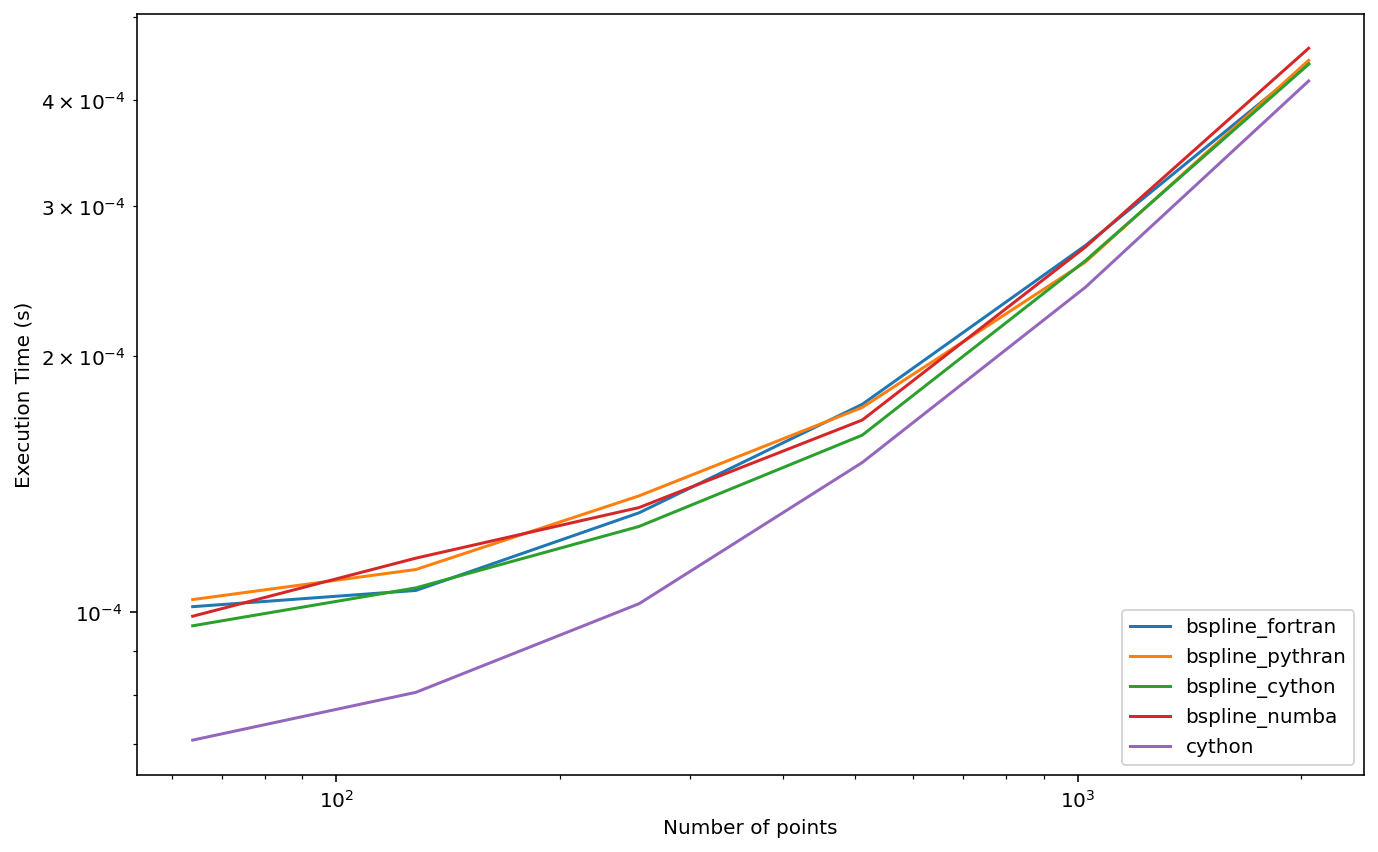

In [22]:
for o, t in times.items():
    plt.loglog(Mrange, t, label=o)
    
plt.legend(loc='lower right')
plt.xlabel('Number of points')
plt.ylabel('Execution Time (s)');

## Vlasov-Poisson system
system for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$

- [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)

In [23]:
class VlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, p = 3, opt=None):
        
        # Grid
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True)
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)
        
        # Distribution function
        self.f = np.zeros((nx,nv))
        
        self.p = p
        
        if opt :
            # Interpolators for advection
            self.cs_x = Advection(p, xmin, xmax, nx, opt)
            self.cs_v = Advection(p, vmin, vmax, nv, opt)
            
        # Modes for Poisson equation
        self.modes = np.zeros(nx)
        k =  2* np.pi / (xmax - xmin)
        self.modes[:nx//2] = k * np.arange(nx//2)
        self.modes[nx//2:] = - k * np.arange(nx//2,0,-1)
        self.modes += self.modes == 0 # avoid division by zero 
        
    def advection_x(self, dt):
        for j in range(self.nv):
            alpha = dt * self.v[j]
            self.f[j,:] = self.cs_x(self.f[j,:], alpha)
            
    def advection_v(self, e, dt):
        for i in range(self.nx):
            alpha = dt * e[i] 
            self.f[:,i] = self.cs_v(self.f[:,i], alpha)
            
    def compute_rho(self):
        rho = self.dv * np.sum(self.f, axis=0)
        return  rho - rho.mean()
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = fft(rho)/self.modes
        return np.real(ifft(-1j*rhok))
    
    def run(self, f, nstep, dt):
        self.f = f
        nrj = []
        self.advection_x(0.5*dt)
        for istep in tqdm(range(nstep)):
            rho = self.compute_rho()
            e = self.compute_e(rho)
            self.advection_v(e, dt)
            self.advection_x(dt)
            nrj.append( 0.5*np.log(np.sum(e*e)*self.dx))
                
        return nrj

## Landau Damping

[Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)

$$
f(x, v, t=0) = \frac{1}{\sqrt{2\pi}} (1 + \epsilon  \cdot cos(k_x \cdot x))  e^{-v^2/2}
$$


 bspline_fortran : 4.5591 



 bspline_pythran : 4.6858 



 bspline_cython : 4.5478 



 bspline_numba : 4.6900 


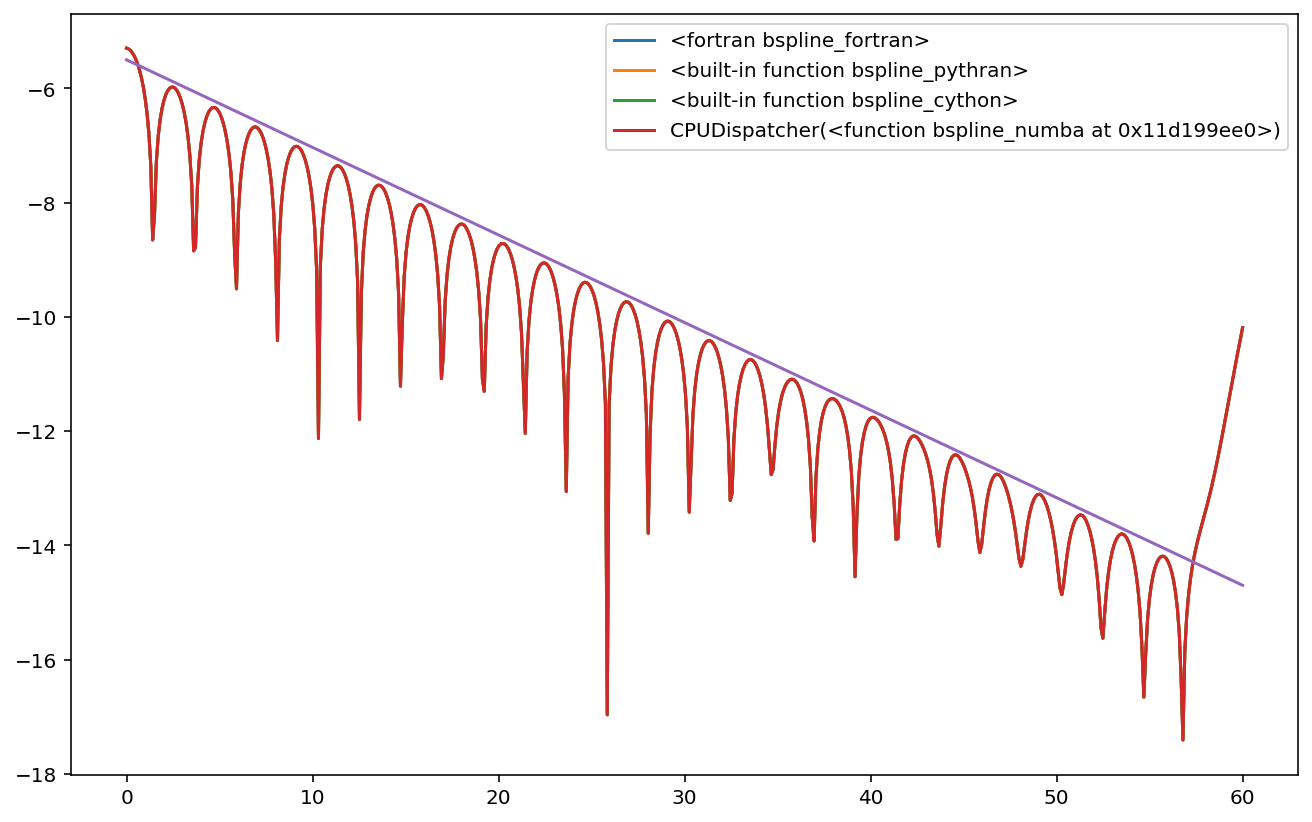

In [24]:
from time import time

elapsed_time = {}
fig, axes = plt.subplots()
for opt in opts:
    
    # Set grid
    nx, nv = 32, 64
    xmin, xmax = 0.0, 4*np.pi
    vmin, vmax = -6., 6.
    
    # Create Vlasov-Poisson simulation
    sim = VlasovPoisson(xmin, xmax, nx, vmin, vmax, nv, opt=opt)

    # Initialize distribution function
    X, V = np.meshgrid(sim.x, sim.v)
    eps, kx = 0.001, 0.5
    f = (1.0+eps*np.cos(kx*X))/np.sqrt(2.0*np.pi)* np.exp(-0.5*V*V)

    # Set time domain
    nstep = 600
    t, dt = np.linspace(0.0, 60.0, nstep, retstep=True)
    
    # Run simulation
    etime = time()
    nrj = sim.run(f, nstep, dt)
    print(" {0:12s} : {1:.4f} ".format(opt.__name__, time()-etime))
    
    # Plot energy
    axes.plot(t, nrj, label=opt)

    
axes.plot(t, -0.1533*t-5.50)
plt.legend();

In [25]:
%%fortran --f90flags "-fopenmp" --extra "-lgomp" --link fftw3

module bsl_fftw

    use, intrinsic :: iso_c_binding
    implicit none
    include 'fftw3.f03'
    
    contains
    
   
    recursive function bspline(p, j, x) result(res)
    
        integer :: p, j
        real(8) :: x, w, w1
        real(8) :: res
     
        if (p == 0) then
            if (j == 0) then
                res = 1.0
                return
            else
                res = 0.0
                return
            end if
        else
            w = (x - j) / p
            w1 = (x - j - 1) / p
        end if
     
        res = w * bspline(p-1,j,x)+(1-w1)*bspline(p-1,j+1,x)
    
    end function bspline
   
    subroutine advection(p, n, delta, alpha, axis, df)
    
        integer, intent(in)     :: p
        integer, intent(in)     :: n
        real(8), intent(in)     :: delta
        real(8), intent(in)     :: alpha(0:n-1)
        integer, intent(in)     :: axis
        real(8), intent(inout)  :: df(0:n-1,0:n-1)
              
        !f2py optional , depend(in) :: n=shape(df,0)
     
        real(8),    allocatable :: f(:)
        complex(8), allocatable :: ft(:)
        real(8),    allocatable :: eig_bspl(:)
        real(8),    allocatable :: modes(:)
        complex(8), allocatable :: eigalpha(:)
        integer(8)              :: fwd
        integer(8)              :: bwd
     
        integer                 :: i
        integer                 :: j
        integer                 :: ishift
        real(8)                 :: beta
        real(8)                 :: pi 
              
        pi = 4.0_8 * atan(1.0_8)
    
        allocate(modes(0:n/2))
        allocate(eigalpha(0:n/2))
        allocate(eig_bspl(0:n/2))
        allocate(f(0:n-1))
        allocate(ft(0:n/2))
     
        do i = 0, n/2
           modes(i) = 2.0_8 * pi * i / n
        end do
      
        call dfftw_plan_dft_r2c_1d(fwd, n, f, ft, FFTW_ESTIMATE)
        call dfftw_plan_dft_c2r_1d(bwd, n, ft, f, FFTW_ESTIMATE)
     
        eig_bspl = 0.0   
        do j = 1, (p+1)/2
           eig_bspl = eig_bspl + bspline(p, j-(p+1)/2, 0.0_8) * 2.0 * cos(j * modes)
        end do
     
        eig_bspl = eig_bspl + bspline(p, -(p+1)/2, 0.0_8)
      
        !$OMP PARALLEL DO DEFAULT(FIRSTPRIVATE), SHARED(df,fwd,bwd)
        do i = 0, n-1
     
            ishift = floor(-alpha(i) / delta)
            beta   = -ishift - alpha(i) / delta
            eigalpha = (0.0_8, 0.0_8)
          
            do j=-(p-1)/2, (p+1)/2+1
               eigalpha = eigalpha + bspline(p, j-(p+1)/2, beta) * exp((ishift+j) * (0.0_8,1.0_8) * modes)
            end do     
            
            if (axis == 0) then
              f = df(:,i)
            else
              f = df(i,:)
            end if
   
            call dfftw_execute_dft_r2c(fwd, f, ft)
            ft = ft * eigalpha / eig_bspl / n
            call dfftw_execute_dft_c2r(bwd, ft, f)
           
            if (axis == 0) then
              df(:,i) = f
            else
              df(i,:) = f
            end if
  
        end do
        !$OMP END PARALLEL DO     
        
        call dfftw_destroy_plan(fwd)
        call dfftw_destroy_plan(bwd)
        deallocate(modes)
        deallocate(eigalpha)
        deallocate(eig_bspl)
        deallocate(f)
        deallocate(ft)
    
    end subroutine advection


end module bsl_fftw

In [26]:
%env OMP_NUM_THREADS=4

env: OMP_NUM_THREADS=4


In [27]:
from tqdm.notebook import tqdm
from scipy.fftpack import fft, ifft

class VlasovPoissonThreaded(VlasovPoisson):
    
    def advection_x(self, dt):
        alpha = dt * self.v
        bsl_fftw.advection(self.p, self.dx, alpha, 1, self.f)        
            
    def advection_v(self, e, dt):
        alpha = dt * e
        bsl_fftw.advection(self.p, self.dv, alpha, 0, self.f)
            


 elapsed time : 0.2917 


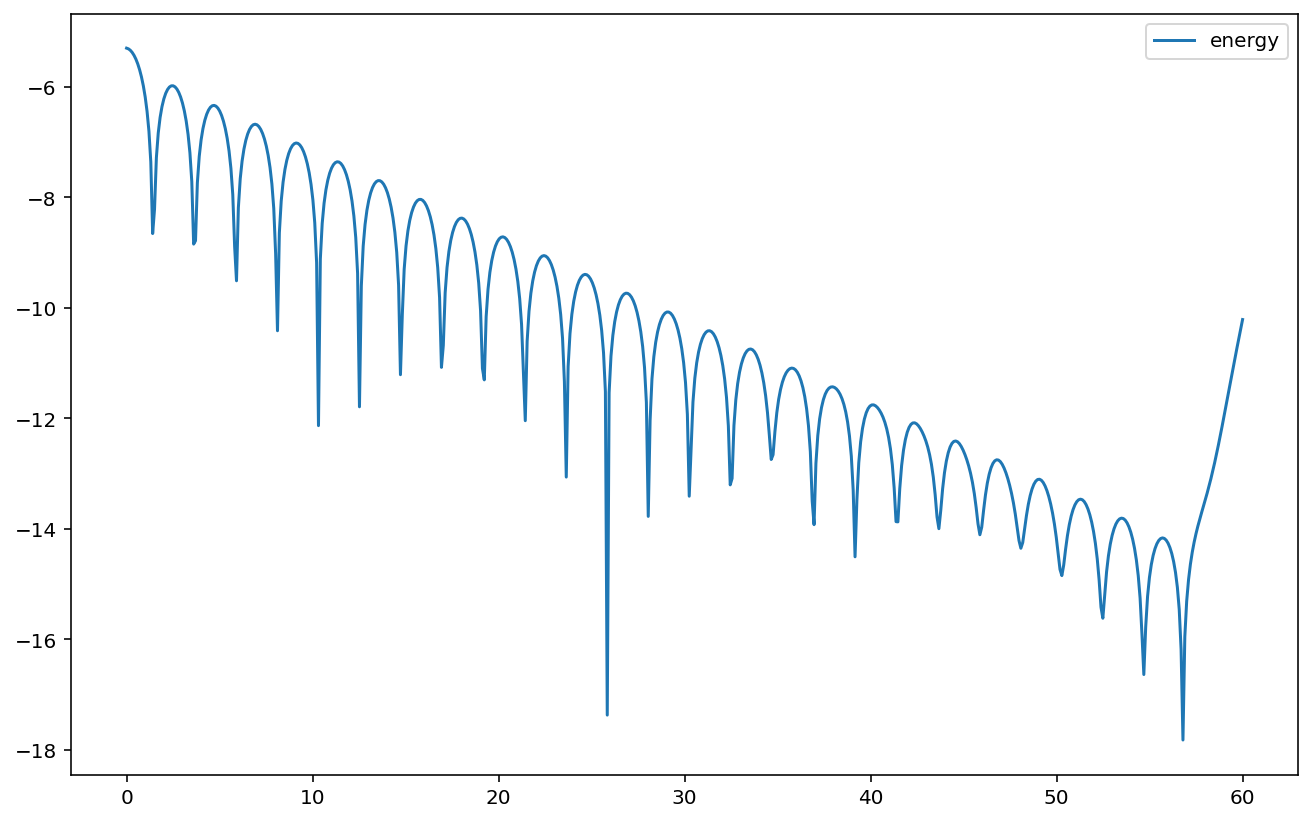

In [28]:
from time import time

elapsed_time = {}
fig, axes = plt.subplots()
# Set grid
nx, nv = 64, 64
xmin, xmax = 0.0, 4*np.pi
vmin, vmax = -6., 6.

# Create Vlasov-Poisson simulation
sim = VlasovPoissonThreaded(xmin, xmax, nx, vmin, vmax, nv)
# Initialize distribution function
X, V = np.meshgrid(sim.x, sim.v)
eps, kx = 0.001, 0.5
f = (1.0+eps*np.cos(kx*X))/np.sqrt(2.0*np.pi)* np.exp(-0.5*V*V)
f = np.asfortranarray(f)
# Set time domain
nstep = 600
t, dt = np.linspace(0.0, 60.0, nstep, retstep=True)

# Run simulation
etime = time()
nrj = sim.run(f, nstep, dt)
print(" elapsed time : {0:.4f} ".format(time()-etime))

# Plot energy
axes.plot(t, nrj, label='energy')

    
plt.legend();